 Importing  libraries

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
os.getcwd()

'/content'

Mounting Google drive into Colab so as to use the Image data from the Drive

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/anime_images_data.zip' -d'/content'

In [ ]:
!ls /content

images


TODO: Recording - please show the location where you have added these images in drive

We need to upload the anime_images folder into Mydrive of Google Drive.
We are loading Anime faces dataset from Google Drive.
Also, normalizing the images to [-1, 1]because the generator’s final layer activation uses tanh

In [4]:
batch_size = 128

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/LL-GANs&DiffusionModelsInMachineLearning/Code/Dataset/anime_images/images', label_mode = None, 
    image_size = (64, 64), batch_size = batch_size
)

train_dataset = train_dataset.map(lambda x: (x / 127.5) - 1)

Found 63565 files belonging to 1 classes.


Visualising a batch of real image data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

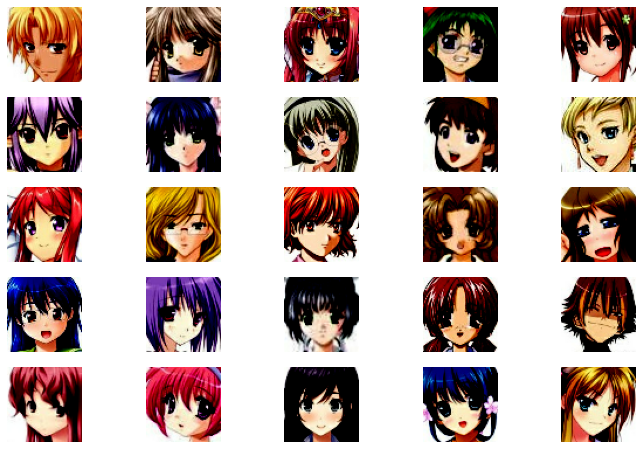

In [5]:
plt.figure(figsize = (12, 8))

for images in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

Retrieving and plotting  a sample image from batch data and checking its shape. Note that as images are colored, third dimension(channel) is 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image_shape (64, 64, 3)


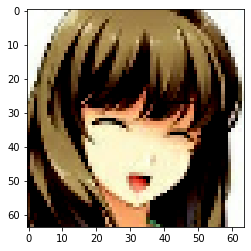

In [6]:
for batch in train_dataset:
    plt.imshow(batch[0])
    print('Image_shape', batch[0].shape)
    break

Both the generator and discriminator are defined using the Keras Sequential API.

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64X64x3. Notice the tf.keras.layers.ReLU activation for each layer, except the output layer which uses tanh.
All the convolution-layer weights are initialized from a zero-centered normal distribution, with a standard deviation of 0.02 as per the original paper.
Blocks 2, 3, and 4 consist of a convolution layer, followed by a batch-normalization layer and an activation function, ReLU. 
The last block comprises no batch-normalization layer, with a sigmoid activation function. 

Note that activation in final layer is tanh which outputs in the range -1 to 1. we reshape the 4*4*256-d tensor to (Batch Size, 4, 4, 256) using layers.Reshape function.Code for GAN architecture is based on this link https://www.kaggle.com/mrigendraagrawal/introduction-to-ganime/notebook and the original paper link on  which architecture is based is here-https://arxiv.org/pdf/1511.06434.pdf

In [7]:
init_weights_kernel = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

In [8]:
def generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape = (100, )))
    model.add(layers.Dense(4 * 4 * 256))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 256)))
    
    model.add(layers.Conv2DTranspose(128, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel , use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(32, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size = 4, padding = 'same', strides = 2, activation = 'tanh',
                                     kernel_initializer = init_weights_kernel, use_bias = False))
   
    
    return model

Building the generator model and summary is obtained

In [9]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

Using the (as yet untrained) generator to create an random colored image.

In [10]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training = False)

generated_image.shape

TensorShape([1, 64, 64, 3])

In [11]:
generated_image[0, :5, :5] 

<tf.Tensor: shape=(5, 5, 3), dtype=float32, numpy=
array([[[ 1.02366983e-04,  5.53706450e-05,  9.04162443e-05],
        [-8.68491334e-05, -4.55547706e-08, -1.35176175e-04],
        [ 1.25522361e-04,  5.47066775e-05,  1.06764091e-04],
        [-1.06701562e-04,  1.72797460e-04,  6.85396226e-05],
        [ 1.77867812e-04,  1.11609217e-04,  9.18942897e-06]],

       [[-3.37994570e-05, -1.13038244e-04,  1.13897557e-04],
        [ 7.68327736e-04, -2.31885148e-04,  7.00012170e-05],
        [-3.02032073e-04,  6.19196566e-04,  2.28584307e-04],
        [-2.41861606e-04, -4.32489702e-04, -6.87524676e-04],
        [ 3.60965030e-04,  3.12989199e-04,  4.32580360e-04]],

       [[-5.49762808e-05,  2.75325001e-05, -2.52561858e-05],
        [ 2.26042175e-04, -2.82991296e-05, -3.61985112e-05],
        [-3.00610962e-04, -2.72676232e-04,  2.46126583e-04],
        [-2.58682485e-05,  2.22798408e-04, -7.26022918e-05],
        [ 8.77182392e-05,  3.69758549e-04,  4.04982071e-04]],

       [[-3.97110707e-05, -3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


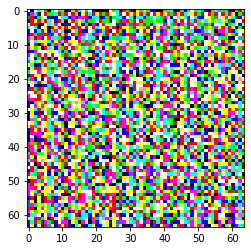

In [12]:
plt.imshow((generated_image[0, :, :, :] * 255 * 100))

The discriminator is a CNN-based image classifier.

Inputs an image of dimension  64 x 64 x 3

Outputs a score between 0 and 1(sigmoid activation in final layer)
Batch normalisation layer is applied for intermediate layers
All the convolution-layer weights are initialized from a zero-centered normal distribution, with a standard deviation of 0.02 as per the original paper.
Has Leaky-Relu (with a slope of 0.2) as an activation function in the intermediate layers along with dropout layers

Has a Sigmoid activation function in the output layer.Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended but we have done it this way  for ease in calculating real and fake scores with their display).

https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D

If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))

In [13]:
def discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 2, input_shape = (64, 64, 3), padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False ))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.ZeroPadding2D(padding = ((0, 1), (0, 1))))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, kernel_size = 3, strides=1, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

Building the discriminator model and summary is obtained

In [14]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        864       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18432     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

Here We are using  the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output values > 0.5  for real images, and values <0.5 for fake images.

In [15]:
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.49999946]], shape=(1, 1), dtype=float32)


Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images

In [16]:
bce = tf.keras.losses.BinaryCrossentropy()

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [18]:
def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

The discriminator and the generator optimizers are different since  two networks would be trained separately.Note that parameters are set as per 2016 paper- https://arxiv.org/pdf/1511.06434.pdf

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

Following code demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using `tf.function`
This annotation causes the function to be "compiled".


In [21]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Notice `training` is set to False.
This is so all layers run in inference mode (batchnorm).
Function for generating and saving images is defined

In [22]:
def generate_and_plot_images(model, epoch, test_input):
  
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)  
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [24]:
def train(dataset, epochs):
    
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list = []
    fake_score_list = []

    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')
        
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
        
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
           
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f,\
               real_score %.2f%%, fake_score %.2f%%'  %
              (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)                 

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list              

Finally, it’s time to train our  GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the  train function calls the train_step function, at every new batch.At the beginning of the training, the generated images looks hazy. As training progresses, the generated images will look more real. The Real and Fake scores seems to be volatile

In [ ]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 497 batches..


Plotting visualisations for Losses and Scores

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(real_score_list, label = 'Real_score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake_score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()